# 산불실황분석이미지로부터 읍·면·동별 산불위험지수 추출

이 Jupyter Notebook은 주기성 산불 실황 분석 이미지로부터 읍·면·동 행정 구역의 대표점을 기준으로 픽셀을 추출하여 읍·면·동 별 산불위험지수를 추출합니다.

## 읍·면·동 행정 구역 경계 데이터 로드

In [144]:
import geopandas as gpd

emd_gdf = gpd.read_file("../data/emd_20230729/emd.shp", encoding='euc-kr')
emd_gdf.geometry = emd_gdf.geometry.set_crs('EPSG:5179')
emd_gdf.geometry = emd_gdf.geometry.to_crs('EPSG:4326')

## EPSG4326 좌표계 -> 산불실황분석이미지 좌표 전사 변환 파악

읍·면·동 행정 구역 경계는 위·경도 데이터로 이루어져 있으며, 해당 경계를 산불실황분석이미지의 경계로 맞춘 후 `(위도, 경도) -> (산불실황분석이미지 픽셀 좌표)`로 변환하는 공식을 찾습니다.

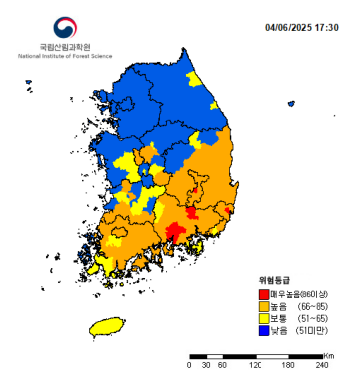

In [145]:
from PIL import Image
import matplotlib.pyplot as plt

fire_risk_img = Image.open('25년04월산불실황분석이미지/obs_sgg_s_archive_2025040617.png')
plt.imshow(fire_risk_img)
plt.axis('off')
plt.show()

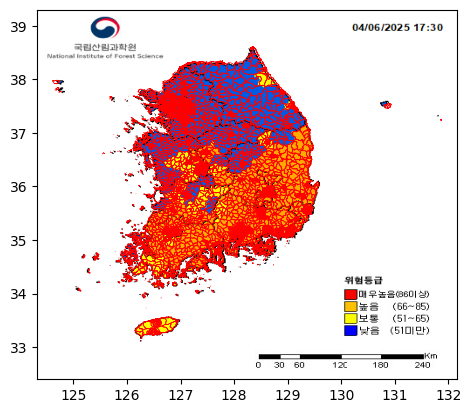

In [146]:
fig, ax = plt.subplots()

# 산불 실황 분석 이미지와 읍면동 경계 데이터가 동일한 좌표에 그려지게끔 이미지의 표시 위치/비율 조정
# 이 값은 직접 조정되었습니다.
image_offset = (124.325, 32.4) 
image_scale = (1.629e-2, 1.317e-2)

# 산불 실황 분석 이미지를 배경에 표시
ax.imshow(fire_risk_img, extent=[image_offset[0], image_offset[0] + fire_risk_img.width * image_scale[0], image_offset[1], image_offset[1] + fire_risk_img.height * image_scale[1]])

# 읍면동 경계 데이터 표시
emd_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)

ax.set_aspect('equal')
plt.show()

In [ ]:
def get_image_coords(xs, ys):
    return ((xs - image_offset[0]) / image_scale[0]).astype(int), (fire_risk_img.size[1] - (ys - image_offset[1]) / image_scale[1]).astype(int)

## 행정 구역 대표점 좌표를 기반으로 각 행정 구역별 산불 위험 지수 계산

In [ ]:
emd_rep_coords = emd_gdf.representative_point()
emd_rep_coord_xs = emd_rep_coords.x.to_numpy()
emd_rep_coord_ys = emd_rep_coords.y.to_numpy()

image_coord_xs, image_coord_ys = get_image_coords(emd_rep_coord_xs, emd_rep_coord_ys)

In [149]:
import numpy as np

def compare_tolerance(color1, color2, tolerance=10):
    return (np.abs(color1 - color2) <= tolerance).all()

# 이 색상 값들은 산불실황분석이미지로부터 추출되었습니다.
risk_very_high_color = np.array([255, 0, 0])
risk_high_color = np.array([255, 170, 0])
risk_medium_color = np.array([255, 255, 0])
risk_low_color = np.array([0, 92, 230])

def get_risk_from_color(color):
    if compare_tolerance(color, risk_very_high_color):
        return 3
    elif compare_tolerance(color, risk_high_color):
        return 2
    elif compare_tolerance(color, risk_medium_color):
        return 1
    elif compare_tolerance(color, risk_low_color):
        return 0
    else:
        # 행정 구역 경계와 산불실황분석이미지가 완전히 일치하지 않기 때문에, 대표점에서의 색이 위 
        # 네 가지 범주에 해당하지 않을 수 있습니다.
        return -1

fire_risk_img_np = np.array(fire_risk_img)

image_coord_xs, image_coord_ys = get_image_coords(emd_rep_coord_xs, emd_rep_coord_ys)
pixels = fire_risk_img_np[image_coord_ys, image_coord_xs]
risks = np.apply_along_axis(get_risk_from_color, -1, pixels)

unique, counts = np.unique(risks, return_counts=True)
print("Unique risks and their counts:")
for risk, count in zip(unique, counts):
    print(f"Risk {risk}: {count} occurrences")

Unique risks and their counts:
Risk -1: 784 occurrences
Risk 0: 1934 occurrences
Risk 1: 474 occurrences
Risk 2: 1707 occurrences
Risk 3: 166 occurrences


### 결측치 개선

세 가지 방식으로 결측치를 제거한다.

1. 만일 결측치를 제외한 나머지가 오직 한 가지 범주라면, 결측치를 해당 범주로 대체
2. 결측 행정 구역의 인접 구역의 `risk` 값을 사용: 인접한 구역들 중 최빈값을 사용: 이 경우 시행마다 비결측 구역이 확장되므로 결측 행정 구역 개수가 수렴할 때까지 시행을 지속한다.
3. 인접한 구역이 없는 경우 대표점을 기준으로 가장 가까운 행정 구역의 `risk` 값을 사용

In [150]:
if -1 in unique and len(counts) == 2:
    risks.fill(unique[1])

In [ ]:
from scipy import stats

def fill_missing_by_adjacent(risks_out):
    missing = risks_out == -1

    valid_rows = emd_gdf[~missing]
    missing_rows = emd_gdf[missing]

    filled = [0] * 4
    for idx, row in missing_rows.iterrows():
        touching_geometry_risks = np.take(risks_out, valid_rows[valid_rows.geometry.touches(row.geometry)].index)
        if len(touching_geometry_risks) != 0:
            # 인접 비결측 행정 구역의 최빈값 사용, 여러 개인 경우 처음 것을 사용
            voted = stats.mode(touching_geometry_risks)[0]
            risks_out[idx] = voted
            filled[voted] += 1
        
    return filled

def fill_missing_by_adjacent_until_converge(risks_out, print_progress=False):
    filled = []
    while True:
        filled.append(fill_missing_by_adjacent(risks_out))
        if filled[-1] == [0, 0, 0, 0]:
            # 결측 행정 구역 개수 수렴
            break

        if print_progress:
            print(filled[-1], end=', ')

    return filled

fill_missing_by_adjacent_until_converge(risks)

[197, 55, 119, 12], [41, 23, 20, 6], [9, 9, 4, 0], [0, 4, 0, 0], [0, 2, 0, 0], [0, 7, 0, 0], [0, 8, 0, 0], [0, 7, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0], 

[[197, 55, 119, 12],
 [41, 23, 20, 6],
 [9, 9, 4, 0],
 [0, 4, 0, 0],
 [0, 2, 0, 0],
 [0, 7, 0, 0],
 [0, 8, 0, 0],
 [0, 7, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 0, 0]]

In [133]:
# 거리 기반 결측치 제거

emd_rep_coord_xs_rad = np.radians(emd_rep_coord_xs)
emd_rep_coord_ys_rad = np.radians(emd_rep_coord_ys)

def fill_missing_by_nearest(risks_out):
    missing = risks_out == -1
    valid_indices = emd_gdf[~missing].index
    missing_indices = emd_gdf[missing].index

    valid_coord_xs_rad = emd_rep_coord_xs_rad.take(valid_indices)
    valid_coord_ys_rad = emd_rep_coord_ys_rad.take(valid_indices)

    filled = [0] * 4
    for missing_index in missing_indices:
        x_rad = emd_rep_coord_xs_rad[missing_index]
        y_rad = emd_rep_coord_ys_rad[missing_index]
        diff_lat = valid_coord_xs_rad - x_rad
        diff_lon = valid_coord_ys_rad - y_rad
        haversine = np.sin(diff_lat / 2) ** 2 + np.cos(x_rad) * np.cos(valid_coord_xs_rad) * np.sin(diff_lon / 2) ** 2
        nearest_idx = np.argmin(haversine)
        voted = risks_out[valid_indices[nearest_idx]]
        risks_out[missing_index] = voted
        filled[voted] += 1

    assert (risks_out != -1).all(), "There are still missing data!"
    return filled

fill_missing_by_nearest(risks)

[0, 0, 0, 0]

## 시각화

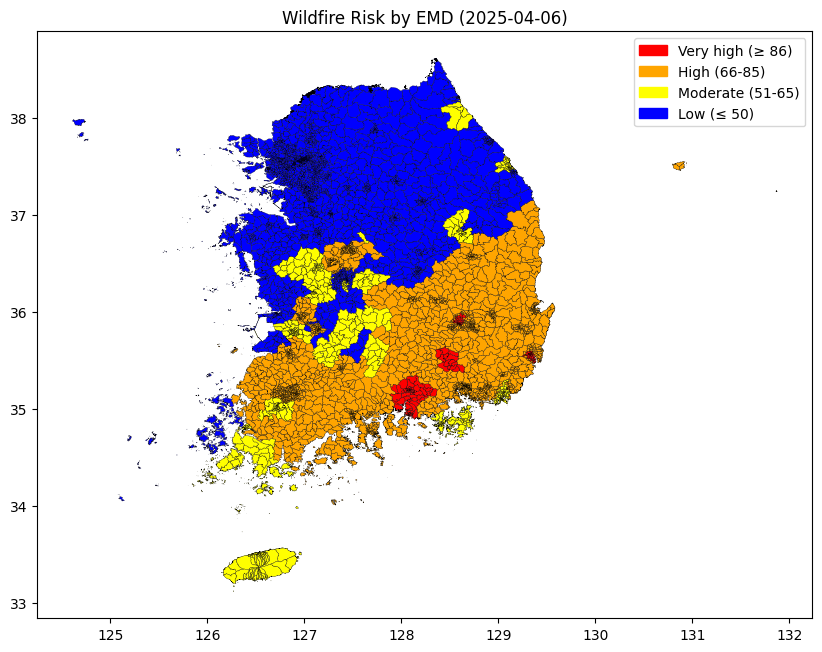

In [92]:
import matplotlib.patches as mpatches

# Define color mapping for risk levels
risk_color_map = {
    0: 'blue',
    1: 'yellow',
    2: 'orange',
    3: 'red',
}

fig, ax = plt.subplots(figsize=(10, 10))
emd_gdf.plot(ax=ax, color=np.vectorize(risk_color_map.__getitem__)(risks), edgecolor='black', linewidth=0.2)

# Create legend patches
ax.legend(handles=[
    mpatches.Patch(color='red', label='Very high (≥ 86)'),
    mpatches.Patch(color='orange', label='High (66-85)'),
    mpatches.Patch(color='yellow', label='Moderate (51-65)'),
    mpatches.Patch(color='blue', label='Low (≤ 50)'),
], loc='upper right')
ax.set_title('Wildfire Risk by EMD (2025-04-06)')
ax.set_aspect('equal')
plt.show()

## 모든 이미지에 대해 시행

In [ ]:
import glob
import os
import pandas as pd

risk_img_dir = '25년04월산불실황분석이미지'
paths = glob.glob(os.path.join(risk_img_dir, "obs_sgg_s_archive_*.png"))

total_df = pd.DataFrame(columns=['EMD_CD', 'YYYYMMDDHH', 'risk'])
for i, path in enumerate(paths):
    # 파일명에서 날짜(YYYYMMDDHH) 추출 및 이미지 로드
    filename = os.path.basename(path)
    ymdh = filename[18:28]
    
    fire_risk_img = Image.open(path)
    assert fire_risk_img.size == (481, 524), "이미지 크기가 EPSG4326 좌표계 -> 산불실황분석이미지 좌표 전사 방식 계산에 사용된 크기와 다름"

    print(f"[{i+1}/{len(paths)}] {filename}: ", end='')

    fire_risk_img_np = np.array(fire_risk_img)

    pixels = fire_risk_img_np[image_coord_ys, image_coord_xs]
    risks = np.apply_along_axis(get_risk_from_color, -1, pixels)

    unique, counts = np.unique(risks, return_counts=True)
    print(*zip(unique, counts), sep=', ')

    if -1 in unique and len(counts) == 2:
        print(f'결측치는 {unique[1]}로 채움')
        risks.fill(unique[1])
    else:
        print('인접 행정 구역 기반 결측치 계산: ', end='')
        fill_missing_by_adjacent_until_converge(risks, print_progress=True)
        print('\n최단 거리 행정 구역 기반 결측치 계산:', fill_missing_by_nearest(risks))

    total_df = pd.concat([total_df, emd_gdf[['EMD_CD']].assign(YYYYMMDDHH=ymdh, risk=risks)], ignore_index=True)

total_df.sort_values(by=['EMD_CD', 'YYYYMMDDHH'], inplace=True, ignore_index=True)
total_df.to_csv(risk_img_dir + '/result.csv', index=False)

[1/718] obs_sgg_s_archive_2025042802.png: (-1, 784), (0, 3723), (1, 447), (2, 111)
인접 행정 구역 기반 결측치 계산: [330, 29, 24, 0], [69, 10, 11, 0], [17, 1, 4, 0], [4, 0, 0, 0], [2, 0, 0, 0], [7, 0, 0, 0], [8, 0, 0, 0], [7, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], 
최단 거리 행정 구역 기반 결측치 계산: [239, 10, 11, 0]
[2/718] obs_sgg_s_archive_2025042816.png: (-1, 784), (0, 159), (1, 368), (2, 3754)
인접 행정 구역 기반 결측치 계산: [45, 66, 272, 0], [16, 31, 43, 0], [3, 15, 4, 0], [0, 4, 0, 0], [0, 2, 0, 0], [0, 7, 0, 0], [0, 8, 0, 0], [0, 7, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0], 
최단 거리 행정 구역 기반 결측치 계산: [31, 113, 116, 0]
[3/718] obs_sgg_s_archive_2025041310.png: (-1, 784), (0, 4137), (1, 144)
인접 행정 구역 기반 결측치 계산: [373, 10, 0, 0], [89, 1, 0, 0], [22, 0, 0, 0], [4, 0, 0, 0], [2, 0, 0, 0], [7, 0, 0, 0], [8, 0, 0, 0], [7, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], 
최단 거리 행정 구역 기반 결측치 계산: [260, 0, 0, 0]
[4/718] obs_sgg_s_archive_2025042619.png: (-1, 784), (0, 1060), (1, 1458), (2, 1763)
인접 행정 구역 기반 결측치 계산: [137, 120, 126, 0], [25, 51, 14, 

In [159]:
total_df

,EMD_CD,YYYYMMDDHH,risk
0,11110101,2025040100,0
1,11110101,2025040101,0
2,11110101,2025040102,0
3,11110101,2025040103,0
4,11110101,2025040104,0
...,...,...,...
3636665,51830350,2025043019,2
3636666,51830350,2025043020,2
3636667,51830350,2025043021,1
3636668,51830350,2025043022,1
